In [1]:
from tool.darknet2pytorch import Darknet
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm

from tool.torch_utils import do_detect
from tool.utils import load_class_names

from pycocotools.coco import COCO
from torch.utils.data import DataLoader
from dataset_coco import COCOImage

import json

In [2]:
anno_json = './../MSCOCO_ObjDet_Detail/new_coco/annotations/new_anno.json'
pred_json = './../YOLOv4_pred.josn'
img_path = './../MSCOCO_ObjDet_Detail/new_coco/images/'

cfgfile = './../cfg/yolov4.cfg'
weights = './../weights/yolov4.weights'

use_cuda = 1

In [3]:
namesfile = 'data/coco.names'
class_names = load_class_names(namesfile)

In [4]:
def coco80_to_coco91_class():  # converts 80-index (val2014) to 91-index (paper)
    # https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
    # a = np.loadtxt('data/coco.names', dtype='str', delimiter='\n')
    # b = np.loadtxt('data/coco_paper.names', dtype='str', delimiter='\n')
    # x1 = [list(a[i] == b).index(True) + 1 for i in range(80)]  # darknet to coco
    # x2 = [list(b[i] == a).index(True) if any(b[i] == a) else None for i in range(91)]  # coco to darknet
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34,
         35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
         64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
    return x

In [5]:
coco_category = coco80_to_coco91_class()

In [6]:
def coco_format(result):
    coco_pred = []
    img_id, boxes, H, W = result
    for box in boxes:
        x1, y1, x2, y2, conf, conf, category_id = box
        
        x1 = x1 * W
        y1 = y1 * H
        
        x2 = x2 * W
        y2 = y2 * H
        
        width = int(x2 - x1)
        height = int(y2 - y1)
        x, y = int(x1), int(y1)
        
        pred_out = {
            "image_id": int(img_id),
            "category_id": int(coco_category[category_id]),
#             "bbox": [x,y,width,height, int(x1), int(x2), int(y1), int(y2)],
            "bbox": [x,y,width,height],
            "score": float(conf),            
        }
        
        coco_pred.append(pred_out)
    return coco_pred

In [7]:
m = Darknet(cfgfile)
m.load_weights(weights)
use_cuda = use_cuda
if use_cuda:
    m.cuda()

convalution havn't activate linear
convalution havn't activate linear
convalution havn't activate linear


In [8]:
# Data Loader
anno = COCO(anno_json)
val_set = COCOImage(anno_json, img_path, 608)
val_loader = DataLoader(val_set, 4, shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


(x1, y1, x2, y2, conf, conf, category_id)
```py
x1 = int(box[0] * width)
y1 = int(box[1] * height)
x2 = int(box[2] * width)
y2 = int(box[3] * height)
```

In [9]:
# Accumulate results
print('STRAT detection')
result_dict = dict([])
for imgs, img_ids, sizes in tqdm(val_loader):
    # model
    boxes = do_detect(m, imgs, conf_thresh=0.4, nms_thresh=0.6, use_cuda=use_cuda, verbose=False)
    # process

    for img_id, box, H, W in zip(img_ids.numpy(), boxes, sizes[0].numpy(), sizes[1].numpy()):
        result_dict[img_id] = (img_id, box, H, W)

  0%|          | 0/25 [00:00<?, ?it/s]

STRAT detection


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


In [10]:
# Transform results to COCO format
print('Convert results to COCO format')
total = []
for img_id in tqdm(result_dict.keys()):
    one_result = coco_format(result_dict[img_id])
    total.extend(one_result)

100%|██████████| 100/100 [00:00<00:00, 9804.59it/s]

Convert results to COCO format


In [11]:
with open(pred_json, 'w')as f:
    json.dump(total, f)

In [12]:
total

[{'image_id': 219578,
  'category_id': 17,
  'bbox': [418, 151, 209, 125],
  'score': 0.7048824429512024},
 {'image_id': 219578,
  'category_id': 18,
  'bbox': [41, 117, 436, 234],
  'score': 0.41605812311172485},
 {'image_id': 219578,
  'category_id': 63,
  'bbox': [5, 63, 622, 338],
  'score': 0.7947282791137695},
 {'image_id': 355257,
  'category_id': 1,
  'bbox': [334, 234, 291, 89],
  'score': 0.5801341533660889},
 {'image_id': 355257,
  'category_id': 65,
  'bbox': [277, 229, 361, 147],
  'score': 0.4864940047264099},
 {'image_id': 355257,
  'category_id': 72,
  'bbox': [-3, 191, 288, 236],
  'score': 0.8165359497070312},
 {'image_id': 355257,
  'category_id': 85,
  'bbox': [7, 85, 161, 155],
  'score': 0.4584762156009674},
 {'image_id': 403385,
  'category_id': 70,
  'bbox': [410, 235, 91, 246],
  'score': 0.9555628299713135},
 {'image_id': 403385,
  'category_id': 81,
  'bbox': [0, 311, 147, 83],
  'score': 0.8385715484619141},
 {'image_id': 286994,
  'category_id': 16,
  'bbox

# eval test

In [13]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [14]:
anno = COCO(anno_json)
pred = anno.loadRes(pred_json)  # init predictions api
eval = COCOeval(anno, pred, 'bbox')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [15]:
eval.evaluate()
eval.accumulate()
eval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.631
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.611
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

# debug

In [16]:
total

[{'image_id': 219578,
  'category_id': 17,
  'bbox': [418, 151, 209, 125],
  'score': 0.7048824429512024},
 {'image_id': 219578,
  'category_id': 18,
  'bbox': [41, 117, 436, 234],
  'score': 0.41605812311172485},
 {'image_id': 219578,
  'category_id': 63,
  'bbox': [5, 63, 622, 338],
  'score': 0.7947282791137695},
 {'image_id': 355257,
  'category_id': 1,
  'bbox': [334, 234, 291, 89],
  'score': 0.5801341533660889},
 {'image_id': 355257,
  'category_id': 65,
  'bbox': [277, 229, 361, 147],
  'score': 0.4864940047264099},
 {'image_id': 355257,
  'category_id': 72,
  'bbox': [-3, 191, 288, 236],
  'score': 0.8165359497070312},
 {'image_id': 355257,
  'category_id': 85,
  'bbox': [7, 85, 161, 155],
  'score': 0.4584762156009674},
 {'image_id': 403385,
  'category_id': 70,
  'bbox': [410, 235, 91, 246],
  'score': 0.9555628299713135},
 {'image_id': 403385,
  'category_id': 81,
  'bbox': [0, 311, 147, 83],
  'score': 0.8385715484619141},
 {'image_id': 286994,
  'category_id': 16,
  'bbox

In [17]:
class_names

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [18]:
anno.cats

{1: {'supercategory': 'person', 'id': 1, 'name': 'person'},
 2: {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 3: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 4: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 5: {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 6: {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 7: {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 8: {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 9: {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 10: {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 11: {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 13: {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 14: {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 15: {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 16: {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 17: {'supercategory': 'animal', 'id': 17, 'name': 'cat'},

In [19]:
class_names[61]

'toilet'

{'image_id': 355257, 'category_id': 1, 'bbox': [334, 234, 291, 89], 'score': 0.5801341533660889}


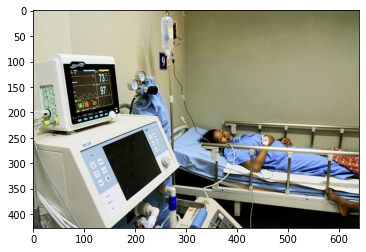

{'supercategory': 'person', 'id': 1, 'name': 'person'}


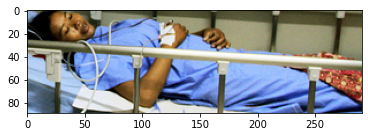

In [20]:
test_img = total[3]
print(test_img)

origin_img = val_set.get_img(test_img['image_id'])
plt.imshow(origin_img)
plt.show()

x,y,w,h = test_img['bbox']
print(anno.cats[test_img['category_id']])
plt.imshow(origin_img[y:y+h, x:x+w])
plt.show()

In [21]:
anns = anno.loadAnns(anno.getAnnIds(test_img['image_id']))

In [22]:
anns[0]['category_id']

44

In [23]:
a = result_dict[16228]
a

(16228,
 [[0.31355348, 0.43510622, 0.3738772, 0.67086464, 0.89340496, 0.89340496, 0],
  [0.4958182, 0.39893597, 0.5432597, 0.5254805, 0.79344445, 0.79344445, 0],
  [0.8517082, 0.37399206, 0.89211667, 0.44534212, 0.7607726, 0.7607726, 0],
  [0.7615414, 0.49610457, 0.84788513, 0.64005506, 0.7440653, 0.7440653, 0],
  [0.18059224, 0.44419947, 0.20490688, 0.58407795, 0.7395494, 0.7395494, 0],
  [0.12241363, 0.44903353, 0.16077231, 0.5938314, 0.72811705, 0.72811705, 0],
  [0.051849194, 0.46134567, 0.08416738, 0.59916663, 0.6559822, 0.6559822, 0],
  [0.104539014, 0.46379662, 0.1234045, 0.595114, 0.6539183, 0.6539183, 0],
  [0.82372844, 0.38305762, 0.8565062, 0.45411292, 0.59136534, 0.59136534, 0],
  [0.16114923, 0.44837973, 0.1840516, 0.5730544, 0.44489905, 0.44489905, 0],
  [0.13748555, 0.45274687, 0.1657144, 0.5866989, 0.40904915, 0.40904915, 0],
  [0.24477597, 0.44726208, 0.26258183, 0.49669445, 0.40163636, 0.40163636, 0],
  [0.80581987, 0.5285747, 0.97206134, 0.66292906, 0.95446503, 0.954

In [24]:
x1, y1, x2, y2, conf, conf, cid = a[1][0]

H = 440
W = 640
x1 = x1 * W
y1 = y1 * H
x2 = x2 * W
y2 = y2 * H
width = int(x2 - x1)
height = int(y2 - y1)
x, y = int(x1), int(y1)

x1, y1 ,x2, y2 = map(int, (x1, y1, x2, y2))

In [25]:
x1, y1 ,x2 ,y2

(200, 191, 239, 295)

In [26]:
width, height

(38, 103)